In [207]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score

from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import chi2
from sklearn import tree, metrics, preprocessing
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import joblib #save and load model
 
train_size = 0.6
validation_size = 0.2
test_size = 0.2



def preprocessing (df):

    #drop 1st row (column title) 
    for row in range(1):
        df = df.drop(row)

    #replace NaN = 0 
    df = df.fillna(0)
    
    #The pd.to_numberic function will convert all non-parsable strings to 'NaN' 
    #and the fillna replaces those values with 0
    df = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
    df = df.astype(int)


    return df



def find_reduced_prediction(y_pred_full, test_df_list):

    y_pred_reduced = []

    for df_id in range(len(test_df_list)):
        start = 0
        for i in range(df_id):
            start += len(test_df_list[i]) 

        end = start + len(test_df_list[df_id])
        step_size = 1
        temp_run_array = y_pred_full[start:end:step_size]

        zeros = list(temp_run_array).count(0)
        ones = list(temp_run_array).count(1)

        if ones > zeros:
            y_pred_reduced.append(1)
        else:
            y_pred_reduced.append(0)

    y_pred_reduced = np.array(y_pred_reduced)

    return y_pred_reduced 



def find_misclassification(y_actual, y_predicted, benign, virus):
    
    misclassified_prog = []
    
    y_actual = y_test_reduced
    y_predicted = y_pred_reduced
    for i in range(len(y_actual)):
        if y_actual[i] == y_predicted[i]:
            print('---')
        else:
            if y_actual[i] == 0:
                print(f'Program {benign[i]}: actual label {y_actual[i]}, predicted as {y_predicted[i]}')
            else:
                
                print(f'Virus Program {virus[i - len(benign)]}: actual label {y_actual[i]}, predicted as {y_predicted[i]}')
    
    return
    
    
    
def find_positive_features(weight):
    
    positive_weight = []
    negative_weight = []
    negative_weight_id = []

    #argsort gives original index of sorted elements
    ascend_id = np.argsort(weight) 

    descend_id = ascend_id[::-1]

    positive_feature_id = list()
    count_positive = 0
    count_negative = 0
    for i in descend_id:
        if np.around(weight[i], 6) > 0:
            count_positive += 1
            positive_feature_id.append(i)
            positive_weight.append(round(weight[i], 3))
        else:
            count_negative += 1
            negative_weight.append(round(weight[i], 3))
            negative_weight_id.append(i)
    return positive_feature_id, positive_weight, negative_weight_id, negative_weight 



def find_feature_meaning(events, feature_id):
    df_preset = pd.read_csv('presets.txt', delimiter=",", header=None, low_memory=False)
    preset = []
    preset__meaning = []
    selected_meaning = []

    for i in range(0, len(df_preset), 2):
        preset.append(df_preset[0][i])

    for i in range(1, len(df_preset), 2):
        preset__meaning.append(df_preset[0][i])



    for i in range(len(feature_id)):
        e = events[feature_id[i]]
        if e in preset:  
            selected_meaning.append(preset__meaning[preset.index(e)])
        else:
            selected_meaning.append('---')
    
    return selected_meaning




mibench6 = [1, 2, 3, 4, 5, 6]
phoronix7 = [7, 8, 9, 10, 11, 12, 13]

benign = mibench6 

virus = [14, 15, 16, 17, 18, 19]

train_df_list = []
validation_df_list = []
test_df_list = []


train_benign_count = 0
validation_benign_count = 0
test_benign_count = 0

train_malware_count = 0
validation_malware_count = 0
test_malware_count = 0


program_len_list = []
for i in benign:
    path = f'dataset/Perf_collection/Base_Model_Training_Files/benign/program{i}.csv'
    df = pd.read_csv(path, delimiter=",", header=None, low_memory=False)
    events = list(df.iloc[0, :])
    df = preprocessing (df)
    
    temp_df_list = []
    for j in range(6):
        temp_df_list.append(df)
        
    df_temp = pd.DataFrame()
    df_temp = pd.concat(temp_df_list, ignore_index=True)
    
    program_len_list.append(len(df_temp))

    #df(frac=1) will randomly select rows;
    # df_train, df_validate, df_test = np.split(df(frac=1), [int(train_size*len(df)), int((train_size + validation_size)*len(df))])

    #without shuffle
#     df_train, df_validate, df_test = np.split(df_temp, [int(train_size*len(df_temp)), int((train_size + validation_size)*len(df_temp))])

    train_benign_count += len(df_temp)
    validation_benign_count += len(df_temp)
    test_benign_count += len(df_temp)

    train_df_list.append(df_temp)
    validation_df_list.append(df_temp)
    test_df_list.append(df_temp)
        
virus_len_list = []
for i in virus:
    path = f'dataset/Perf_collection/Base_Model_Training_Files/virus/program{i}.csv'
    df = pd.read_csv(path, delimiter=",", header=None, low_memory=False)
    events = list(df.iloc[0, :])
    df = preprocessing (df)
    virus_len_list.append(len(df))

    #df.sample(frac=1) will randomly select rows;
    # df_train, df_validate, df_test = np.split(df(frac=1), [int(train_size*len(df)), int((train_size + validation_size)*len(df))])

    #without shuffle
#     df_train, df_validate, df_test = np.split(df, [int(train_size*len(df)), int((train_size + validation_size)*len(df))])


    train_malware_count += len(df)
    validation_malware_count += len(df)
    test_malware_count += len(df)

    train_df_list.append(df)
    validation_df_list.append(df)
    test_df_list.append(df)

    
    
df_train = pd.DataFrame()
df_validation = pd.DataFrame()
df_test = pd.DataFrame()

df_train = pd.concat(train_df_list, ignore_index=True)
df_validation = pd.concat(validation_df_list, ignore_index=True)
df_test = pd.concat(test_df_list, ignore_index=True)


#generate labels
b = [0 if i < train_benign_count else 1 for i in range( train_benign_count + train_malware_count )]
y_train = np.array(b)

y_train_reduced = [0 for i in range(len(benign))]
for i in range(len(virus)):
    y_train_reduced.append(1)
y_train_reduced = np.array(y_train_reduced)


b = [0 if i < validation_benign_count else 1 for i in range( validation_benign_count + validation_malware_count )]
y_validation = np.array(b)


y_validation_reduced = [0 for i in range(len(benign))]
for i in range(len(virus)):
    y_validation_reduced.append(1)
y_validation_reduced = np.array(y_validation_reduced)


b = [0 if i < test_benign_count else 1 for i in range( test_benign_count + test_malware_count )]
y_test = np.array(b)

y_test_reduced = [0 for i in range(len(benign))]
for i in range(len(virus)):
    y_test_reduced.append(1)
y_test_reduced = np.array(y_test_reduced)

print(len(program_len_list), program_len_list)
print(len(virus_len_list), virus_len_list)

13 [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
6 [13000, 13000, 13000, 13000, 13000, 13000]


In [208]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,59996,3644,81683,3099,17185,2627581,2322716,2554896,6414,288324,...,84,0,320,274667,698,0,0,2609,0,0
1,29698,1300,41469,556,6750,2814123,2922207,2810952,6303,41119,...,338,0,0,11938,181,0,0,180,0,0
2,6946,241,9704,108,7728,2674490,2517595,2672640,0,17103,...,164,0,0,8637,135,0,0,110,0,0
3,5080,262,8588,124,9778,2677551,2402964,2677656,0,17129,...,1718,0,0,2129,14,0,0,83,0,0
4,2033,89,3528,88,9689,2625424,2039815,2648856,0,15005,...,510,0,12,2948,27,5,0,217,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155995,12063,57,3527,34,414,68330,13843,68280,33885,103529,...,43,0,0,13027,109,0,0,0,0,0
155996,12859,53,3897,39,414,68480,13844,68376,0,74473,...,20,0,0,11199,95,0,0,0,0,0
155997,11545,52,3399,35,982,109999,21013,109800,0,92500,...,51,0,0,10752,90,0,0,0,0,0
155998,13020,87,4453,69,416,68102,13838,67848,0,127558,...,68,0,12,20746,106,6,0,0,0,0


In [209]:
df_validation

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,59996,3644,81683,3099,17185,2627581,2322716,2554896,6414,288324,...,84,0,320,274667,698,0,0,2609,0,0
1,29698,1300,41469,556,6750,2814123,2922207,2810952,6303,41119,...,338,0,0,11938,181,0,0,180,0,0
2,6946,241,9704,108,7728,2674490,2517595,2672640,0,17103,...,164,0,0,8637,135,0,0,110,0,0
3,5080,262,8588,124,9778,2677551,2402964,2677656,0,17129,...,1718,0,0,2129,14,0,0,83,0,0
4,2033,89,3528,88,9689,2625424,2039815,2648856,0,15005,...,510,0,12,2948,27,5,0,217,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155995,12063,57,3527,34,414,68330,13843,68280,33885,103529,...,43,0,0,13027,109,0,0,0,0,0
155996,12859,53,3897,39,414,68480,13844,68376,0,74473,...,20,0,0,11199,95,0,0,0,0,0
155997,11545,52,3399,35,982,109999,21013,109800,0,92500,...,51,0,0,10752,90,0,0,0,0,0
155998,13020,87,4453,69,416,68102,13838,67848,0,127558,...,68,0,12,20746,106,6,0,0,0,0


In [210]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,59996,3644,81683,3099,17185,2627581,2322716,2554896,6414,288324,...,84,0,320,274667,698,0,0,2609,0,0
1,29698,1300,41469,556,6750,2814123,2922207,2810952,6303,41119,...,338,0,0,11938,181,0,0,180,0,0
2,6946,241,9704,108,7728,2674490,2517595,2672640,0,17103,...,164,0,0,8637,135,0,0,110,0,0
3,5080,262,8588,124,9778,2677551,2402964,2677656,0,17129,...,1718,0,0,2129,14,0,0,83,0,0
4,2033,89,3528,88,9689,2625424,2039815,2648856,0,15005,...,510,0,12,2948,27,5,0,217,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155995,12063,57,3527,34,414,68330,13843,68280,33885,103529,...,43,0,0,13027,109,0,0,0,0,0
155996,12859,53,3897,39,414,68480,13844,68376,0,74473,...,20,0,0,11199,95,0,0,0,0,0
155997,11545,52,3399,35,982,109999,21013,109800,0,92500,...,51,0,0,10752,90,0,0,0,0,0
155998,13020,87,4453,69,416,68102,13838,67848,0,127558,...,68,0,12,20746,106,6,0,0,0,0


In [212]:
df_train_cp = df_train.copy()
df_validation_cp = df_validation.copy()
df_test_cp = df_test.copy()

# df_eva_cp = df_X_eva.copy()

#-------PowerTransformer, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, MinMaxScaler
#QuantileTransformer(output_distribution='normal'), QuantileTransformer(output_distribution='uniform')

# scaler = QuantileTransformer(output_distribution='normal')
# # scaler = Normalizer()

# df_tr  = pd.DataFrame(scaler.fit_transform(df_train_cp))
# df_val  = pd.DataFrame(scaler.fit_transform(df_validation_cp))
# df_ts  = pd.DataFrame(scaler.fit_transform(df_test_cp))

# df_eva  = pd.DataFrame(scaler.fit_transform(df_eva_cp))


# used_features = [0, 1, 3, 4, 5, 6, 7, 12]
used_features = [0, 1, 3, 4, 5, 6, 7, 16 ]

df_train_cp = df_train_cp[used_features]
df_validation_cp = df_validation_cp[used_features]
df_test_cp = df_test_cp[used_features]


# df_tr = df_tr[used_features]
# df_val = df_val[used_features]
# df_ts = df_ts[used_features]

In [213]:
df_train_cp

,0,1,3,4,5,6,7,16
0,59996,3644,3099,17185,2627581,2322716,2554896,3794
1,29698,1300,556,6750,2814123,2922207,2810952,5950
2,6946,241,108,7728,2674490,2517595,2672640,0
3,5080,262,124,9778,2677551,2402964,2677656,0
4,2033,89,88,9689,2625424,2039815,2648856,0
...,...,...,...,...,...,...,...,...
155995,12063,57,34,414,68330,13843,68280,11
155996,12859,53,39,414,68480,13844,68376,7
155997,11545,52,35,982,109999,21013,109800,60
155998,13020,87,69,416,68102,13838,67848,0


In [214]:
df_test_cp

,0,1,3,4,5,6,7,16
0,59996,3644,3099,17185,2627581,2322716,2554896,3794
1,29698,1300,556,6750,2814123,2922207,2810952,5950
2,6946,241,108,7728,2674490,2517595,2672640,0
3,5080,262,124,9778,2677551,2402964,2677656,0
4,2033,89,88,9689,2625424,2039815,2648856,0
...,...,...,...,...,...,...,...,...
155995,12063,57,34,414,68330,13843,68280,11
155996,12859,53,39,414,68480,13844,68376,7
155997,11545,52,35,982,109999,21013,109800,60
155998,13020,87,69,416,68102,13838,67848,0


In [215]:
# #-----------------------------------------------------------------

# base LR on original data

# model = ExtraTreesClassifier()
# model.fit(df_tr, y_train)
# feat_importances = pd.Series(model.feature_importances_, index = df_tr.columns)

acc_prow = []
acc_pprog = []


print('used_features', used_features)

lr_model_perf = LogisticRegression(solver='liblinear', max_iter=2000)
lr_model_perf.fit(df_train_cp, y_train)

joblib.dump(lr_model_perf, "model/lr_model_perf.pkl")
lr_model_perf = joblib.load("model/lr_model_perf.pkl")

probs_y = lr_model_perf.predict_proba(df_validation_cp)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_validation, probs_y)
optimal_th = round(thresholds[np.argmax(tpr - fpr)], 2)

probs_y = lr_model_perf.predict_proba(df_test_cp)[:,1]
y_pred = [1 if i > optimal_th else 0 for i in probs_y]

y_pred_reduced = find_reduced_prediction(y_pred, test_df_list)

accuracy  = round(np.mean(y_pred == y_test), 2)
acc_prow.append(accuracy)

accuracy  = round(np.mean(y_pred_reduced == y_test_reduced), 2)
acc_pprog.append(accuracy)

print('acc_prow:', acc_prow)
print('acc_pprog', acc_pprog)

used_features [0, 1, 3, 4, 5, 6, 7, 16]
acc_prow: [0.71]
acc_pprog [0.79]


In [216]:
for i in used_features:
    print(i, events[i])

0 Branch-instructions
1 Branch-misses
3 Cache-misses
4 Cache-references
5 CPU-cycles
6 Instructions
7 Ref-cycles
16 branch-load-misses


In [126]:
# Add 100 to -ve features
# base LR


weight = lr_model_all_features.coef_[0]
positive_feature_id, positive_weight, negative_feature_id, negative_weight = find_positive_features(weight)


lr_acc_ts_prow = []
lr_acc_ts_pprog = []


df_ts_cp[35].values[:] =  df_ts_cp[35].values[:] + 100 


y_pred = lr_model_all_features.predict(df_ts_cp)

y_pred_reduced = find_reduced_prediction(y_pred, run_length)

accuracy  = round(np.mean(y_pred == y_test), 2)
lr_acc_ts_prow.append(accuracy)

accuracy  = round(np.mean(y_pred_reduced == y_test_reduced), 2)
lr_acc_ts_pprog.append(accuracy)



print(f'base LR on "TEST DATA [35] + 100": accuracy per row : {lr_acc_ts_prow}\n')
print(f'base LR on "TEST DATA [35] + 100": accuracy per prog : {lr_acc_ts_pprog}\n')







base LR on "TEST DATA [35] + 100": accuracy per row : [0.48]
base LR on "TEST DATA [35] + 100": accuracy per prog : [0.48]



Monotonic LR on "ORIGINAL test data": accuracy per row: [0.67]
Monotonic LR on "ORIGINAL test data": accuracy per prog: [0.8]

Monotonic LR on "EVASIVE [fork method]": accuracy per row: [1.0]
Monotonic LR on "EVASIVE [fork method]": accuracy per prog: [1.0]



/Users/shohidul/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


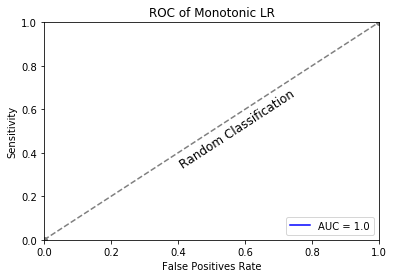

In [78]:
# Add 100 to feature 35
# monotonic LR

lr_acc_ts_prow = []
lr_acc_ts_pprog = []

monotonic_feature = [6, 19, 50, 22]


# df_ts_cp[35].values[:] =  df_ts_cp[35].values[:] + 100


# df_ts  = pd.DataFrame(scaler.fit_transform(df_ts_cp))


# for col in df_ts.columns:
#         if col not in monotonic_feature:
#             df_ts[col].values[:] = 0
    


# # probs_y = lr_model_all_features.predict_proba(df_val)[:,1]
# # print(f'LR validation optimal threshold: {optimal_th}\n')

    
# probs_y = lr_model_all_features.predict_proba(df_ts)[:,1]

# y_pred = [1 if i > 0.99 else 0 for i in probs_y]
# y_pred_reduced = find_reduced_prediction(y_pred, run_length)
# accuracy  = round(np.mean(y_pred == y_test), 2)
# lr_acc_ts_prow.append(accuracy)
# accuracy  = round(np.mean(y_pred_reduced == y_test_reduced), 2)
# lr_acc_ts_pprog.append(accuracy)

# print(f'Monotonic LR on "TEST DATA [35] + 100": accuracy per row: {lr_acc_ts_prow}')
# print(f'Monotonic LR on "TEST DATA [35] + 100": accuracy per prog: {lr_acc_ts_pprog}\n')


lr_acc_ts_prow = []
lr_acc_ts_pprog = []


for col in df_ts.columns:
        if col not in monotonic_feature:
            df_ts[col].values[:] = 0


probs_y = lr_model_all_features.predict_proba(df_ts)[:,1]

y_pred = [1 if i > 0.99 else 0 for i in probs_y]
y_pred_reduced = find_reduced_prediction(y_pred, run_length)
accuracy  = round(np.mean(y_pred == y_test), 2)
lr_acc_ts_prow.append(accuracy)
accuracy  = round(np.mean(y_pred_reduced == y_test_reduced), 2)
lr_acc_ts_pprog.append(accuracy)

print(f'Monotonic LR on "ORIGINAL test data": accuracy per row: {lr_acc_ts_prow}')
print(f'Monotonic LR on "ORIGINAL test data": accuracy per prog: {lr_acc_ts_pprog}\n')




lr_acc_ts_prow = []
lr_acc_ts_pprog = []



for col in df_eva_cp.columns:
        if col not in monotonic_feature:
            df_eva_cp[col].values[:] = 0


probs_y = lr_model_all_features.predict_proba(df_eva_cp)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_eva, probs_y)
auc = metrics.auc(fpr, tpr)
y_pred = [1 if i > 0.99 else 0 for i in probs_y]
y_pred_reduced = find_reduced_prediction(y_pred, run_length)
accuracy  = round(np.mean(y_pred == y_eva), 2)
lr_acc_ts_prow.append(accuracy)
accuracy  = round(np.mean(y_pred_reduced == y_eva_reduced), 2)
lr_acc_ts_pprog.append(accuracy)


print(f'Monotonic LR on "EVASIVE [fork method]": accuracy per row: {lr_acc_ts_prow}')
print(f'Monotonic LR on "EVASIVE [fork method]": accuracy per prog: {lr_acc_ts_pprog}\n')


from pylab import text
plt.figure()

plt.plot(fpr, tpr, label = f'AUC = {round(accuracy, 2)}', color = 'blue')

text(0.4, 0.33, 'Random Classification', fontsize=12, rotation = 33)

plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.plot([0, 1], [0, 1], 'k--', color = 'gray', linestyle = '--', marker = 'o')
plt.xlabel('False Positives Rate')
plt.ylabel('Sensitivity')
plt.title('ROC of Monotonic LR')
plt.legend(loc="lower right")
plt.savefig('figure/ROC_mono_LR.pdf', bbox_inches='tight')
plt.show() 






In [29]:
probs_y

array([1., 1., 1., ..., 1., 1., 1.])

In [100]:
# Add 100 to feature 35
# feature importance

lr_acc_ts_prow = []
lr_acc_ts_pprog = []

important_feature = [20, 22, 0, 35]


df_ts_cp[20].values[:] =  df_ts_cp[20].values[:] + 100
df_ts_cp[35].values[:] =  df_ts_cp[35].values[:] + 100


# df_ts = scaler.fit_transform(df_ts_cp)
# df_ts  = pd.DataFrame(df_ts)

df_X_test_reduced_feature = df_ts_cp[important_feature]

probs_y = lr_reduced.predict_proba(df_X_test_reduced_feature)[:,1]
y_pred = [1 if i > optimal_th else 0 for i in probs_y]
y_pred_reduced = find_reduced_prediction(y_pred, run_length)
accuracy  = round(np.mean(y_pred == y_test), 2)
lr_acc_ts_prow.append(accuracy)
accuracy  = round(np.mean(y_pred_reduced == y_test_reduced), 2)
lr_acc_ts_pprog.append(accuracy)



print(f'feature importance LR on "TEST DATA + 100": accuracy per row : {lr_acc_ts_prow}')
print(f'feature importance LR on "TEST DATA + 100": accuracy per prog: {lr_acc_ts_pprog}\n')





feature importance LR on "TEST DATA + 100": accuracy per row : [0.52]
feature importance LR on "TEST DATA + 100": accuracy per prog: [0.52]



In [79]:
# LR feature importance

lr_acc_ts_prow = []
lr_acc_ts_pprog = []

lr_acc_eva_prow = []
lr_acc_eva_pprog = []


important_feature = [20, 22, 0, 35]


print(f'feature_used: {important_feature}')

df_X_train_reduced_feature = df_tr[important_feature]
df_X_validate_reduced_feature = df_val[important_feature]
df_X_test_reduced_feature = df_ts[important_feature]
df_eva_reduced_feature = df_eva[important_feature]


lr_reduced = joblib.load("lr_reduced.pkl")


probs_y = lr_reduced.predict_proba(df_X_validate_reduced_feature)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_validation, probs_y)
optimal_th = round(thresholds[np.argmax(tpr - fpr)], 2)

print(f'LR validation optimal threshold: {optimal_th}\n')

probs_y = lr_reduced.predict_proba(df_X_test_reduced_feature)[:,1]
y_pred = [1 if i > optimal_th else 0 for i in probs_y]
y_pred_reduced = find_reduced_prediction(y_pred, run_length)
accuracy  = round(np.mean(y_pred == y_test), 2)
lr_acc_ts_prow.append(accuracy)
accuracy  = round(np.mean(y_pred_reduced == y_test_reduced), 2)
lr_acc_ts_pprog.append(accuracy)

probs_y = lr_reduced.predict_proba(df_eva_reduced_feature)[:,1]
y_pred = [1 if i > optimal_th else 0 for i in probs_y]
y_pred_reduced = find_reduced_prediction(y_pred, run_length)
accuracy  = round(np.mean(y_pred == y_eva), 2)
lr_acc_eva_prow.append(accuracy)
accuracy  = round(np.mean(y_pred_reduced == y_eva_reduced), 2)
lr_acc_eva_pprog.append(accuracy)     


print(f'feature importance LR on original test data: accuracy per row : {lr_acc_ts_prow}')
print(f'feature importance LR on original test data: accuracy per prog : {lr_acc_ts_pprog}\n')

print(f'feature importance LR on EVASIVE test data [fork method]: accuracy per row : {lr_acc_eva_prow}')
print(f'feature importance LR on EVASIVE test data [fork method]: accuracy per prog : {lr_acc_eva_pprog}\n')



feature_used: [20, 22, 0, 35]
LR validation optimal threshold: 0.5

feature importance LR on original test data: accuracy per row : [0.73]
feature importance LR on original test data: accuracy per prog : [0.96]

feature importance LR on EVASIVE test data [fork method]: accuracy per row : [0.5]
feature importance LR on EVASIVE test data [fork method]: accuracy per prog : [0.53]



In [42]:
# reading evasive dataset
temp = []
for v in range(7):

    if v == 2:
        continue
    
    path = f'dataset/new_data/evasive/virus{v+1}withaddedhpcs.csv'
    df = pd.read_csv(path, delimiter=",", header=None, low_memory=False)
    events_eva = df.iloc[0, :]
    df = preprocessing (df)
    temp.append(df)

run_length_eva = len(df)

df_temp = pd.DataFrame()
df_temp =  pd.concat(temp, ignore_index=True)

df_X_eva = df_temp.copy()

#generate evasive labels
y_eva = np.array([1 for i in range(len(df_X_eva))])
y_eva_reduced = np.array([1 for i in range(int(len(y_eva)/run_length_eva))])

In [21]:
temp = []
for i in range(2):
    
    if i == 2:
        continue
    
    for j in range(1):
        path = f'dataset/new_data/1000us/Virus{i+1}/Virus{i+1}run{j+1}.csv'
        df = pd.read_csv(path, delimiter=",", header=None, low_memory=False)
        events = df.iloc[0, :]
        df = preprocessing (df)
        temp.append(df)

df_before = pd.DataFrame()
df_before =  pd.concat(temp, ignore_index=True)


temp = []
for v in range(1):

    if v == 2:
        continue
        
    for j in range(2):
#         path = f'dataset/new_data/evasive/Flushing_array_and_reload_method-5/all_hpc/Virus{v+1}/Virus{v+1}run{j+1}.csv'
        path = f'dataset/new_data/evasive/virus{j+1}withaddedhpcs.csv'
        df = pd.read_csv(path, delimiter=",", header=None, low_memory=False)
        events_eva = df.iloc[0, :]
        df = preprocessing (df)
        temp.append(df)


df_after = pd.DataFrame()
df_after =  pd.concat(temp, ignore_index=True)

len(df_before)

len(df_after)

feature = [6, 19, 50, 22, 35]
events = list(events)


x = [i+1 for i in range(len(df_before)) ]
x = pd.DataFrame(x)

for col in feature:
    plt.figure()

    y1 = df_before[col]
    y2 = df_after[col]
    
#     y1 = pd.DataFrame(df_ts_cp[col].values[0:len(df_before)])
#     y2 = y1 

    plt.plot(x,y1, label = 'before fork attack')
    plt.plot(x,y2, label = 'after fork attack')

    plt.xlabel('samples')
    plt.ylabel('count')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, - 0.15), frameon=False, ncol = 2)
    
    meaning = find_feature_meaning(events, [col])
    
    plt.title(f'run={j+1}  {col}: {events[col]}: {meaning[0]}')
    
    filename = f'figure/feature{col}_run{j+1}.pdf'
    
    plt.savefig(filename, bbox_inches='tight')